In [ ]:
! pip install torchinfo

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

from numpy.random import seed
import torch

from torchinfo import summary
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


### Load MINST Dataset

Download the benchmark dataset MNIST from “http://yann.lecun.com/exdb/mnist/”. Implement multiclass logistic regression and try it on MNIST.

In [ ]:
train_dataset = torchvision.datasets.MNIST('./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST('./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=False)

In [ ]:
# train: 1 mini batch contains 128 observations
train_iterator = train_loader.__iter__()
train_sample_image, train_sample_label = next(train_iterator)

# test: 1 mini batch contains 128 observations
valid_iterator = test_loader.__iter__()
valid_sample_image, valid_sample_label = next(valid_iterator)

# print
print('Train Sample')
print('1 of 128 train sample', train_sample_image.shape)
print('1 of 128 train label', train_sample_label.shape)
print('Test Sample')
print('1 of 128 test sample', valid_sample_image.shape)
print('1 of 128 test label', valid_sample_label.shape)

Train Sample
1 of 128 train sample torch.Size([128, 1, 28, 28])
1 of 128 train label torch.Size([128])
Test Sample
1 of 128 test sample torch.Size([128, 1, 28, 28])
1 of 128 test label torch.Size([128])


In [ ]:
train_sample_image[1].shape

torch.Size([1, 28, 28])

## Visualize data

Text(0.5, 1.0, 'Ground Truth: 5')

([], <a list of 0 Text major ticklabel objects>)

([], <a list of 0 Text major ticklabel objects>)

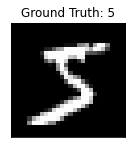

In [ ]:
fig = plt.figure()
cur_data, cur_label = train_dataset[0]
plt.subplot(2,3,0+1)
plt.tight_layout()
plt.imshow(cur_data[0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(cur_label))
plt.xticks([])
plt.yticks([])

## Question 1

### Three - layer feedforward network 

In [ ]:
class FeedForward(nn.Module):  
    def __init__(self, p, hidden_l1, hidden_l2):  
        super(FeedForward, self).__init__()  
        self.classifier = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(in_features=784, out_features=hidden_l1),  
            nn.ReLU(),
            nn.Linear(in_features=hidden_l1, out_features=hidden_l2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_l2, out_features=10)
        )
    def forward(self, x):
        x = x.reshape(-1, 28 * 28).to(device)
        x = self.classifier(x)

        return x

In [ ]:
visual_model = FeedForward(p=0,hidden_l1=500,hidden_l2=500)
visual_model

FeedForward(
  (classifier): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            # self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32, weight_decay=0):

    # move model to device
    model = model.to(device)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # training loop
    print('Training Starts ')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        for x, y in train_dataset:
            
            # x = x.to(device)
            y = y.to(device)
            outputs = model(x)  # (num_batch)
            
            cur_train_loss = criterion(outputs, y)
            cur_train_loss.backward()  # run back propagation
            optimizer.step()  # optimizer update all model parameters
            optimizer.zero_grad()  # set gradient to zero, avoid gradient accumulating
            # loss
            train_loss += cur_train_loss
            # acc
            _, pred_class = torch.max(outputs, 1)
            train_acc += (pred_class == y).sum().item() / batch_size

      # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for images, labels in test_dataset:
                images = images.reshape(-1, 28 * 28).to(device)
                # images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                _, pred_class = torch.max(outputs, 1)
                val_acc += (pred_class == labels).sum().item() / batch_size
        
        # print & record
        train_loss = train_loss / len(train_dataset)
        train_acc = train_acc / len(train_dataset)
        val_loss = val_loss / len(test_dataset)
        val_acc = val_acc / len(test_dataset)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

regularizer=0
dropout = 0
model = FeedForward(p=dropout,hidden_l1=500,hidden_l2=500)
hista = train_model(model, 
                    train_loader, 
                    test_loader, 
                    device, 
                    lr=0.0001, 
                    epochs=250, 
                    batch_size=128, 
                    weight_decay=regularizer)

Training Starts 
Epoch:1 / 250, train loss:0.67600, train acc: 0.84108, valid loss:0.29017, valid acc:0.90823
Epoch:2 / 250, train loss:0.26816, train acc: 0.92246, valid loss:0.22524, valid acc:0.92316
Validation loss decreased (inf --> 0.225237).  Saving model ...
Epoch:3 / 250, train loss:0.21135, train acc: 0.93922, valid loss:0.18747, valid acc:0.93424
Validation loss decreased (0.225237 --> 0.187466).  Saving model ...
Epoch:4 / 250, train loss:0.17518, train acc: 0.94906, valid loss:0.15900, valid acc:0.94165
Validation loss decreased (0.187466 --> 0.159004).  Saving model ...
Epoch:5 / 250, train loss:0.14788, train acc: 0.95659, valid loss:0.14045, valid acc:0.94848
Validation loss decreased (0.159004 --> 0.140446).  Saving model ...
Epoch:6 / 250, train loss:0.12734, train acc: 0.96302, valid loss:0.12179, valid acc:0.95362
Validation loss decreased (0.140446 --> 0.121788).  Saving model ...
Epoch:7 / 250, train loss:0.11059, train acc: 0.96800, valid loss:0.11018, valid acc:

Text(0.5, 1.0, 'Classification Accuracy')

<function matplotlib.pyplot.plot>

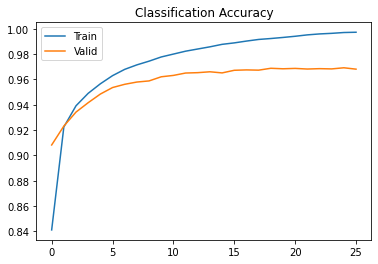

In [ ]:
plt.plot(hista['train_acc'], label='Train')
plt.plot(hista['test_acc'], label='Valid')
plt.title("Classification Accuracy")
plt.legend()
plt.plot

Text(0.5, 1.0, 'Cross entropy loss')

<function matplotlib.pyplot.plot>

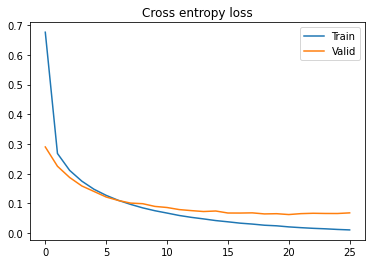

In [ ]:
plt.plot(hista['train_loss'], label='Train')
plt.plot(hista['test_loss'], label='Valid')
plt.title("Cross entropy loss")
plt.legend()
plt.plot

### Three - layer feedforward network with regularizers 

L2 reqularization 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

regularizer = 0.0001
model_with_reqularizer = FeedForward(p=dropout,hidden_l1=500,hidden_l2=500)
hist_l2_reqularizer = train_model(model_with_reqularizer, 
                    train_loader, 
                    test_loader, 
                    device, 
                    lr=0.0001, 
                    epochs=250, 
                    batch_size=128, 
                    weight_decay=regularizer)

Training Starts 
Epoch:1 / 250, train loss:0.67680, train acc: 0.84863, valid loss:0.29058, valid acc:0.90704
Epoch:2 / 250, train loss:0.26639, train acc: 0.92372, valid loss:0.22564, valid acc:0.92573
Validation loss decreased (inf --> 0.225637).  Saving model ...
Epoch:3 / 250, train loss:0.21113, train acc: 0.93880, valid loss:0.18623, valid acc:0.93463
Validation loss decreased (0.225637 --> 0.186232).  Saving model ...
Epoch:4 / 250, train loss:0.17395, train acc: 0.94951, valid loss:0.16052, valid acc:0.94195
Validation loss decreased (0.186232 --> 0.160522).  Saving model ...
Epoch:5 / 250, train loss:0.14718, train acc: 0.95722, valid loss:0.13726, valid acc:0.94689
Validation loss decreased (0.160522 --> 0.137259).  Saving model ...
Epoch:6 / 250, train loss:0.12783, train acc: 0.96277, valid loss:0.12647, valid acc:0.94986
Validation loss decreased (0.137259 --> 0.126472).  Saving model ...
Epoch:7 / 250, train loss:0.11163, train acc: 0.96755, valid loss:0.11296, valid acc:

Text(0.5, 1.0, 'Classification Accuracy')

<function matplotlib.pyplot.plot>

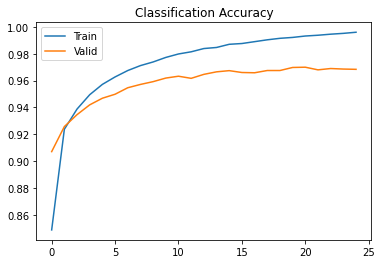

In [ ]:
plt.plot(hist_l2_reqularizer['train_acc'], label='Train')
plt.plot(hist_l2_reqularizer['test_acc'], label='Valid')
plt.title("Classification Accuracy - L2 regularizer model")
plt.legend()
plt.plot

Text(0.5, 1.0, 'Cross entropy loss')

<function matplotlib.pyplot.plot>

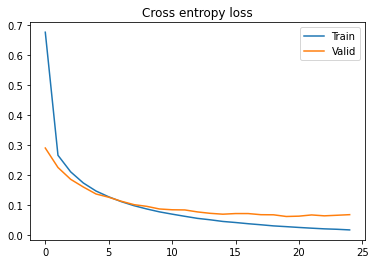

In [ ]:
plt.plot(hist_l2_reqularizer['train_loss'], label='Train')
plt.plot(hist_l2_reqularizer['test_loss'], label='Valid')
plt.title("Cross entropy loss - L2 regularizer model")
plt.legend()
plt.plot

Dropout

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dropout = 0.3
model_with_reqularizer = FeedForward(p=dropout,hidden_l1=500,hidden_l2=500)
hist_dropout_reqularizer = train_model(model_with_reqularizer, 
                    train_loader, 
                    test_loader, 
                    device, 
                    lr=0.0001, 
                    epochs=250, 
                    batch_size=128, 
                    weight_decay=regularizer)

Training Starts 
Epoch:1 / 250, train loss:0.74647, train acc: 0.80983, valid loss:0.31080, valid acc:0.90467
Epoch:2 / 250, train loss:0.33497, train acc: 0.90037, valid loss:0.24413, valid acc:0.91901
Validation loss decreased (inf --> 0.244134).  Saving model ...
Epoch:3 / 250, train loss:0.27636, train acc: 0.91788, valid loss:0.20145, valid acc:0.93038
Validation loss decreased (0.244134 --> 0.201453).  Saving model ...
Epoch:4 / 250, train loss:0.23766, train acc: 0.92914, valid loss:0.17268, valid acc:0.93780
Validation loss decreased (0.201453 --> 0.172676).  Saving model ...
Epoch:5 / 250, train loss:0.20485, train acc: 0.93883, valid loss:0.14799, valid acc:0.94571
Validation loss decreased (0.172676 --> 0.147994).  Saving model ...
Epoch:6 / 250, train loss:0.18301, train acc: 0.94566, valid loss:0.13416, valid acc:0.94798
Validation loss decreased (0.147994 --> 0.134160).  Saving model ...
Epoch:7 / 250, train loss:0.16340, train acc: 0.95066, valid loss:0.11977, valid acc:

Text(0.5, 1.0, 'Classification Accuracy')

<function matplotlib.pyplot.plot>

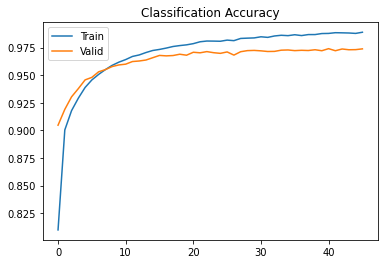

In [ ]:
plt.plot(hist_dropout_reqularizer['train_acc'], label='Train')
plt.plot(hist_dropout_reqularizer['test_acc'], label='Valid')
plt.title("Classification Accuracy - Model with Dropout")
plt.legend()
plt.plot

Text(0.5, 1.0, 'Cross entropy loss')

<function matplotlib.pyplot.plot>

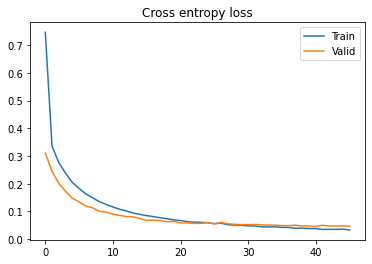

In [ ]:
plt.plot(hist_dropout_reqularizer['train_loss'], label='Train')
plt.plot(hist_dropout_reqularizer['test_loss'], label='Valid')
plt.title("Cross entropy loss - Model with Dropout")
plt.legend()
plt.plot

### Comparisions 

### Comparision of models without regularizer and model with L2 regularizer

Text(0.5, 1.0, 'Comparing test accuracies')

Text(0.5, 0, 'Epochs')

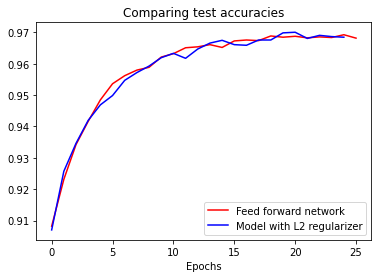

In [ ]:
plt.plot(hista['test_acc'], 'r-', label='Feed forward network')
plt.plot(hist_l2_reqularizer['test_acc'], 'b-', label='Model with L2 regularizer')

plt.title('Comparing test accuracies')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Comparing test loss')

Text(0.5, 0, 'Epochs')

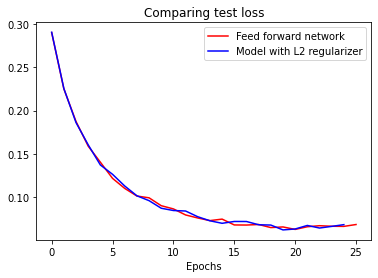

In [ ]:
plt.plot(hista['test_loss'], 'r-', label='Feed forward network')
plt.plot(hist_l2_reqularizer['test_loss'], 'b-', label='Model with L2 regularizer')

plt.title('Comparing test loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

### Comparision of models without regularizer and model with dropout

Text(0.5, 1.0, 'Comparing test accuracies')

Text(0.5, 0, 'Epochs')

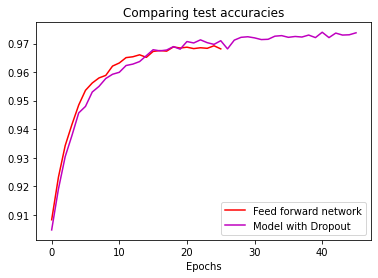

In [ ]:
plt.plot(hista['test_acc'], 'r-', label='Feed forward network')
plt.plot(hist_dropout_reqularizer['test_acc'], 'm-', label='Model with Dropout')

plt.title('Comparing test accuracies')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Comparing test loss')

Text(0.5, 0, 'Epochs')

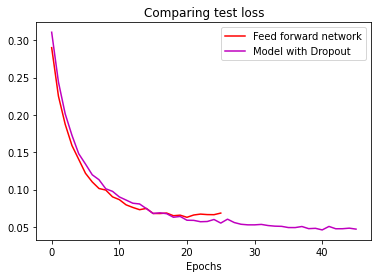

In [ ]:
plt.plot(hista['test_loss'], 'r-', label='Feed forward network')
plt.plot(hist_dropout_reqularizer['test_loss'], 'm-', label='Model with Dropout')

plt.title('Comparing test loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

### Comparision of models without regularizer, model with L2 regulizer and model with dropout

Text(0.5, 1.0, 'Comparing test accuracies')

Text(0.5, 0, 'Epochs')

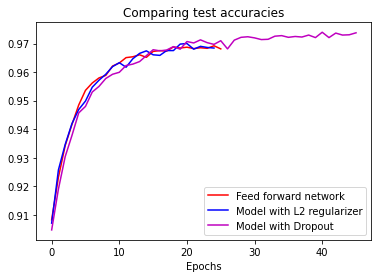

In [ ]:
plt.plot(hista['test_acc'], 'r-', label='Feed forward network')
plt.plot(hist_l2_reqularizer['test_acc'], 'b-', label='Model with L2 regularizer')
plt.plot(hist_dropout_reqularizer['test_acc'], 'm-', label='Model with Dropout')

plt.title('Comparing test accuracies')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Comparing test loss')

Text(0.5, 0, 'Epochs')

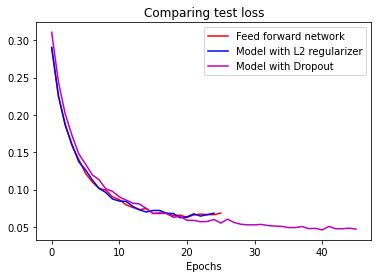

In [ ]:
plt.plot(hista['test_loss'], 'r-', label='Feed forward network')
plt.plot(hist_l2_reqularizer['test_loss'], 'b-', label='Model with L2 regularizer')
plt.plot(hist_dropout_reqularizer['test_loss'], 'm-', label='Model with Dropout')

plt.title('Comparing test loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## Question 2 

### Convolutional neural network

In [ ]:
class SimpleConvnet(nn.Module):
    def __init__(self):
        super(SimpleConvnet, self).__init__()
        # conv net
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),  # (32, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #(32, 13, 13)  if stride is not provided, it will default to kernel_size

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # (64, 11, 11),  param = (3*3*32+1)*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 5, 5)
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),  # (64, 3, 3)
            nn.Flatten() # 64*3*3 features after flattening 
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=576, out_features=500),  # 576 = 64 * 3 * 3
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=10)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)

        return x

In [ ]:
visual_model = SimpleConvnet()
summary(visual_model, (10, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleConvnet                            --                        --
├─Sequential: 1-1                        [10, 576]                 --
│    └─Conv2d: 2-1                       [10, 32, 26, 26]          320
│    └─ReLU: 2-2                         [10, 32, 26, 26]          --
│    └─MaxPool2d: 2-3                    [10, 32, 13, 13]          --
│    └─Conv2d: 2-4                       [10, 64, 11, 11]          18,496
│    └─ReLU: 2-5                         [10, 64, 11, 11]          --
│    └─MaxPool2d: 2-6                    [10, 64, 5, 5]            --
│    └─Conv2d: 2-7                       [10, 64, 3, 3]            36,928
│    └─Flatten: 2-8                      [10, 576]                 --
├─Sequential: 1-2                        [10, 10]                  --
│    └─Dropout: 2-9                      [10, 576]                 --
│    └─Linear: 2-10                      [10, 500]                 288,500
│

In [ ]:
def train(model, train_dataset, test_dataset, device, 
                lr=0.0002, epochs=30, batch_size=256):
    
    # # construct dataloader
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)
    early_stopping = EarlyStopping(patience=5, verbose=True)


    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x)
                _, pred = torch.max(outputs, dim = -1)
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc   

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train acc:{train_acc:.5f}, valid loss:{val_loss:.5f} valid acc:{val_acc:.5f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return history

In [ ]:
# define model
model = SimpleConvnet()

history = train(model, 
                train_dataset, 
                test_dataset, 
                device, 
                lr=0.0001, 
                epochs=250, 
                batch_size=128)


Training Start
Epoch:1 / 250, train loss:0.48010 train acc:0.85245, valid loss:0.18877 valid acc:0.93078
Epoch:2 / 250, train loss:0.18287 train acc:0.94283, valid loss:0.11906 valid acc:0.95164
Validation loss decreased (inf --> 0.119056).  Saving model ...
Epoch:3 / 250, train loss:0.12419 train acc:0.96089, valid loss:0.07010 valid acc:0.96657
Validation loss decreased (0.119056 --> 0.070101).  Saving model ...
Epoch:4 / 250, train loss:0.09832 train acc:0.96858, valid loss:0.05731 valid acc:0.97122
Validation loss decreased (0.070101 --> 0.057314).  Saving model ...
Epoch:5 / 250, train loss:0.08177 train acc:0.97408, valid loss:0.05753 valid acc:0.96984
EarlyStopping counter: 1 out of 5
Epoch:6 / 250, train loss:0.07091 train acc:0.97740, valid loss:0.04450 valid acc:0.97518
Validation loss decreased (0.057314 --> 0.044502).  Saving model ...
Epoch:7 / 250, train loss:0.06156 train acc:0.98016, valid loss:0.03855 valid acc:0.97646
Validation loss decreased (0.044502 --> 0.038550).

Text(0.5, 1.0, 'Classification Accuracy - CNN')

Text(0.5, 0, 'Epochs')

<function matplotlib.pyplot.plot>

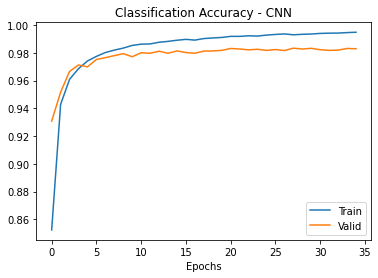

In [ ]:
plt.plot(history['train_acc'], label='Train')
plt.plot(history['test_acc'], label='Valid')
plt.title("Classification Accuracy - CNN")
plt.xlabel('Epochs')
plt.legend()
plt.plot

Text(0.5, 1.0, 'Cross-entropy loss - CNN')

<function matplotlib.pyplot.plot>

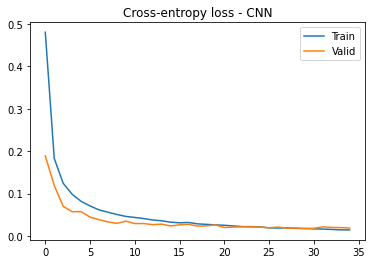

In [ ]:
plt.plot(history['train_loss'], label='Train')
plt.plot(history['test_loss'], label='Valid')
plt.title("Cross-entropy loss - CNN")
plt.legend()
plt.plot

### Comparision of models without regularizer, model with L2 regularizer, model with dropout and CNN

Text(0.5, 1.0, 'Comparing test accuracies')

Text(0.5, 0, 'Epochs')

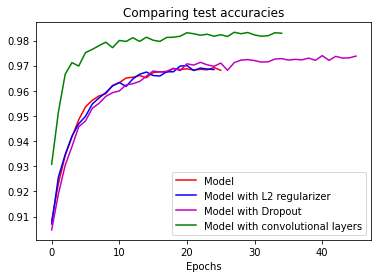

In [ ]:
plt.plot(hista['test_acc'], 'r-', label='Model')
plt.plot(hist_l2_reqularizer['test_acc'], 'b-', label='Model with L2 regularizer')
plt.plot(hist_dropout_reqularizer['test_acc'], 'm-', label='Model with Dropout')
plt.plot(history['test_acc'], 'g-', label='Model with convolutional layers')

plt.title('Comparing test accuracies')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Comparing test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

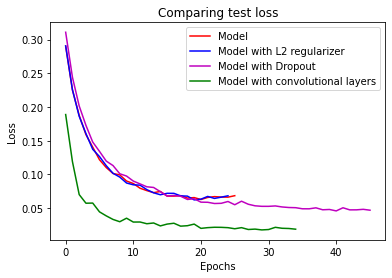

In [ ]:
plt.plot(hista['test_loss'], 'r-', label='Model')
plt.plot(hist_l2_reqularizer['test_loss'], 'b-', label='Model with L2 regularizer')
plt.plot(hist_dropout_reqularizer['test_loss'], 'm-', label='Model with Dropout')
plt.plot(history['test_loss'], 'g-', label='Model with convolutional layers')


plt.title('Comparing test loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()